In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import sys
import time
import gc
import itertools
import tqdm
import time
import copy

import scipy.stats as ss
from numba import jit

if os.name=='nt':
    try:
        mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
        os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
    except:
        pass
    
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

### Helper Function

In [2]:
def lag_features(df, lags, merge_cols, shift_cols, fillna_value=None):
    '''create lag features of col'''
    cols = copy.copy(merge_cols)
    cols.extend(shift_cols)
    tmp = df.loc[:, cols]
    for i in lags:
        shifted = tmp.copy()
        shifted_cols = shifted.columns.tolist()
        shifted_cols = [c+'_lag_'+str(i) if c in shift_cols else c 
                        for c in shifted_cols]
        shifted.columns = shifted_cols
        shifted['month'] += i
        shifted.drop_duplicates(inplace=True)
        df = pd.merge(df, shifted, on=merge_cols, how='left')
    if fillna_value is not None:
        df.fillna(fillna_value, inplace=True)
    return df    

In [3]:
def clip_rmse(preds, dtrain):
    y_test = np.array(dtrain.get_label())
    preds = np.array(preds)
    y_test = np.maximum(np.minimum(y_test, 20), 0)
    preds = np.maximum(np.minimum(preds, 20), 0)
    #preds = np.array(list(map(lambda x: min(20, max(x, 0)), list(preds))))
    #y_test = np.array(list(map(lambda x: min(20, max(x, 0)), list(y_test))))
    rmse = np.sqrt(mean_squared_error(preds,y_test))
    return 'clip-rmse', rmse

In [4]:
def cv(x_train, y_train, param, n_repetition, n_split, n_tree, verbose, random_state):
    '''Repeated CV'''
    
    cv_results = {}
    clf = {}
    running_time = {}

    np.random.seed(random_state)

    for m in range(n_repetition):
        # Train and valuation sets split
        skf = StratifiedKFold(n_splits=n_split, random_state=np.random.randint(10**6), shuffle=True)

        for n, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):

            start_time = time.time()

            # Construct DMatrix
            dtrain = xgb.DMatrix(x_train.iloc[train_index], label=y_train.iloc[train_index])
            dval = xgb.DMatrix(x_train.iloc[val_index], label=y_train.iloc[val_index])

            # Placeholder for evals_results
            cv_results[m, n] = {}

            param['seed'] = np.random.randint(10**6)
            clf[m, n] = xgb.train(param, dtrain,num_boost_round=n_tree, 
                                  evals=[(dtrain, 'train'), (dval, 'val')], 
                                  feval=clip_rmse, maximize=False, early_stopping_rounds=None, 
                                  evals_result=cv_results[m, n], verbose_eval=verbose)

            running_time[m, n] = time.time() - start_time

            print('Repeat {}, split {}, val score = {:.3f}, running time = {:.3f} min.'.format(m, n, 
                cv_results[m, n]['val']['clip-rmse'][-1], running_time[m, n]/60))

    cv_results_final = {}
    for m in range(n_repetition):
        for n in range(n_split):
            cv_results_final['train', m, n] = cv_results[m, n]['train']['clip-rmse']
            cv_results_final['val', m, n] = cv_results[m, n]['val']['clip-rmse']

    df = pd.DataFrame(cv_results_final)
    df.index.name = 'iteration'
    df.columns.names = ['dataset', 'repetition', 'cv_split']

    print('Val mean = {:.3f}, std = {:.3f}'.format(df['val'].iloc[-1].mean(), df['val'].iloc[-1].std()))
    
    return df, clf, running_time

In [5]:
def feature_combination(x, feature_list, function_dict, column_name, merge=False):
    '''Combination of new features'''
    tmp = x.groupby(feature_list).agg(function_dict)
    tmp.columns = column_name
    if merge:
        x = x.merge(tmp, on=feature_list, how='left')
        return x, tmp
    else:
        return tmp

### Load and Preprocess Data

In [6]:
# Load data
train = pd.read_csv('all/sales_train.csv.gz')
test = pd.read_csv('all/test.csv.gz')
shop = pd.read_csv('all/shops-translated.csv')
item = pd.read_csv('all/item_category.csv')

test.set_index('ID', inplace=True)
item.drop(['item_name_translated'], axis=1, inplace=True)
shop.drop(['Name'], axis=1, inplace=True)

le = LabelEncoder()
item['item_cat1'] = le.fit_transform(item['item_cat1'].astype(str))
item['item_cat2'] = le.fit_transform(item['item_cat2'].astype(str))
shop['City'] = le.fit_transform(shop['City'])
shop['Type'] = le.fit_transform(shop['Type'])

Remove outliers

In [7]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

Fix shop names and ids

In [8]:
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

Monthly sales for all the samples

In [9]:
x = pd.DataFrame(train.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum())

x.reset_index(inplace=True)

Training set only contains sold samples, need to extend to all samples.

There are two ways of extending:
1. overall product between elements in (month, shop_id, item_id)
2. in each month, the product between elements in (shop_id, item_id)

The first one increases the number of rows by 23.5 times, the second one 6 times

In [10]:
shop_count = {}
item_count = {}
product_count = {}
sample_count = {}
ratio = {}

for n in x.date_block_num.unique():
    shop_count[n] = len(x.loc[x.date_block_num==n, 'shop_id'].unique())
    item_count[n] = len(x.loc[x.date_block_num==n, 'item_id'].unique())
    sample_count[n] = len(x.loc[x.date_block_num==n, :])
    product_count[n] = shop_count[n]*item_count[n]
    ratio[n] = product_count[n]/sample_count[n]
#     print('product count is {}, sample count is {}, ratio is {:.3f}'.format(product_count[n], 
#                                                                             sample_count[n], 
#                                                                             product_count[n]/sample_count[n]))
    
print('overall product count is {}, sample count is {}, ratio is {:.3f}'.format(
    len(x.shop_id.unique())*len(x.item_id.unique())*34, 
    x.shape[0], 34*len(x.shop_id.unique())*len(x.item_id.unique())/x.shape[0]))
print('monthly product count sum is {}, monthly sample count is {}, ratio is {:.3f}'.format(
    sum(product_count.values()), sum(sample_count.values()), sum(product_count.values())/sum(sample_count.values())))

overall product count is 42260028, sample count is 1609123, ratio is 26.263
monthly product count sum is 10913804, monthly sample count is 1609123, ratio is 6.782


Try the first extending method

It requires huge RAM

In [11]:
if False:
    month = np.arange(0, 34)
    shop_list = train.shop_id.unique().tolist()
    item_list = train.item_id.unique().tolist()
    n_rows = len(month)*len(shop_list)*len(item_list)

    idx = pd.MultiIndex.from_product([month, shop_list, item_list], names=['date_block_num', 'shop_id', 'item_id'])

    x2 = pd.DataFrame(np.zeros((n_rows,2)), index=idx)
    x2.reset_index(inplace=True, drop=False)
    x2.drop([0, 1], axis=1, inplace=True)

    x = x2.merge(x, on=['date_block_num', 'shop_id', 'item_id'], how='outer').fillna(0.0)
    test['date_block_num'] = 34
    x = pd.concat((x, test), sort=False).fillna(0.0)

    del x2
    gc.collect()

Try the second method

In [12]:
tmp = []
for n in range(34):
    shop_list = x.loc[x.date_block_num==n, 'shop_id'].unique()
    item_list = x.loc[x.date_block_num==n, 'item_id'].unique()
    idx = pd.MultiIndex.from_product([[n], shop_list, item_list], names=['date_block_num', 'shop_id', 'item_id'])
    df_tmp = pd.DataFrame(np.zeros((len(idx),2)), index=idx)
    tmp.append(df_tmp)
tmp = pd.concat(tmp, sort=False)
tmp.reset_index(inplace=True, drop=False)
tmp.drop([0, 1], axis=1, inplace=True)
x = tmp.merge(x, on=['date_block_num', 'shop_id', 'item_id'], how='outer').fillna(0.0)
test['date_block_num'] = 34
x = pd.concat((x, test), sort=False).fillna(0.0)

Add shop/item features

In [13]:
x = pd.merge(x, shop, on='shop_id', how='left')
x = pd.merge(x, item, on='item_id', how='left')

Change column names

In [14]:
x.columns = ['month', 'shop_id', 'item_id', 'sales_month', 
             'City', 'Type', 'item_cat1', 'item_cat2']

Change column types

In [15]:
x['City'] = x['City'].astype(np.int8)
x['Type'] = x['Type'].astype(np.int8)
x['item_cat1'] = x['item_cat1'].astype(np.int8)
x['item_cat2'] = x['item_cat2'].astype(np.int8)
x['sales_month'] = x['sales_month'].astype(np.float16)
x['month'] = x['month'].astype(np.int8)
x['shop_id'] = x['shop_id'].astype(np.int8)

### Target Lags

In [16]:
x = lag_features(x, [1, 2, 3, 6, 12], 
                 ['month', 'shop_id', 'item_id'], 
                 ['sales_month'], fillna_value=0)

### Mean Encoding

`sales_mean_month`

In [17]:
group = x.groupby('month').agg({'sales_month': ['mean']})
group.columns = ['sales_mean_month']
group.reset_index(inplace=True)

x = pd.merge(x, group, on=['month'], how='left')
x['sales_mean_month'] = x['sales_mean_month'].astype(np.float16)
x = lag_features(x, [1], ['month'], ['sales_mean_month'], fillna_value=0.0)
x.drop(['sales_mean_month'], axis=1, inplace=True)

`sales_mean_month_item`

In [18]:
col = 'sales_mean_month_item'
group = x.groupby(['month', 'item_id']).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=['month', 'item_id'], how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1, 2, 3, 6, 12], 
                 ['month', 'item_id'], 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

`sales_mean_month_shop`

In [19]:
col = 'sales_mean_month_shop'
merge_cols = ['month', 'shop_id']
group = x.groupby(merge_cols).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=merge_cols, how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1, 2, 3, 6, 12], 
                 merge_cols, 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

`sales_mean_month_cat1`

In [20]:
col = 'sales_mean_month_cat1'
merge_cols = ['month', 'item_cat1']
group = x.groupby(merge_cols).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=merge_cols, how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1], 
                 merge_cols, 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

`sales_mean_month_shop_cat1`

In [21]:
col = 'sales_mean_month_shop_cat1'
merge_cols = ['month', 'shop_id', 'item_cat1']
group = x.groupby(merge_cols).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=merge_cols, how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1], 
                 merge_cols, 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

`sales_mean_month_shop_type`

In [22]:
col = 'sales_mean_month_shop_type'
merge_cols = ['month', 'shop_id', 'Type']
group = x.groupby(merge_cols).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=merge_cols, how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1], 
                 merge_cols, 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

`sales_mean_month_shop_cat2`

In [23]:
col = 'sales_mean_month_shop_cat2'
merge_cols = ['month', 'shop_id', 'item_cat2']
group = x.groupby(merge_cols).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=merge_cols, how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1], 
                 merge_cols, 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

`sales_mean_month_city`

In [24]:
col = 'sales_mean_month_city'
merge_cols = ['month', 'City']
group = x.groupby(merge_cols).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=merge_cols, how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1], 
                 merge_cols, 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

`sales_mean_month_item_city`

In [25]:
col = 'sales_mean_month_item_city'
merge_cols = ['month', 'item_id', 'City']
group = x.groupby(merge_cols).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=merge_cols, how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1], 
                 merge_cols, 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

`sales_mean_month_cat2`

In [26]:
col = 'sales_mean_month_cat2'
merge_cols = ['month', 'item_cat2']
group = x.groupby(merge_cols).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=merge_cols, how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1], 
                 merge_cols, 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

`sales_mean_month_cat1_cat2`

In [27]:
col = 'sales_mean_month_cat1_cat2'
merge_cols = ['month', 'item_cat1', 'item_cat2']
group = x.groupby(merge_cols).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=merge_cols, how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1, 2, 3, 6], 
                 merge_cols, 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

#### CV

In [28]:
if False:
    x.replace([np.inf, -np.inf], np.nan, inplace=True)
    x.fillna(0.0, inplace=True)

In [29]:
# Split train and test sets
x_train = x.loc[(x['month']<=33) & (x['month']>=12), :].copy()
x_test = x.loc[x['month']==34, :].copy()

# Drop target from test set
x_test.drop(['sales_month'], axis=1, inplace=True)

# Split target from train set
# Note that target is first clipped to (0, 40), then clipped to (0, 20) in test set. 
# This is similar to the idea of calibration
y_train = x_train['sales_month'].clip(0, 40)
x_train.drop(['sales_month'], axis=1, inplace=True)

In [30]:
param = {'max_depth':8, 
         'subsample':0.8,
         'min_child_weight':10,
         'eta':0.3, 
         'lambda':2,
         'colsample_bytree':0.8,
         'seed':1,
         'silent':1,
         'maximize': False,
         'nthread':8}

n_tree = 80
verbose = True

n_split = 3
n_repetition = 1

df, clf, running_time = cv(x_train, y_train, param, n_repetition, n_split, n_tree, verbose, 42)

C:\Users\lyaa\AppData\Local\Continuum\miniconda3\envs\kaggle\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[0]	train-rmse:1.27292	val-rmse:1.27885	train-clip-rmse:1.04041	val-clip-rmse:1.04506
[1]	train-rmse:1.17087	val-rmse:1.1794	train-clip-rmse:0.954435	val-clip-rmse:0.961319
[2]	train-rmse:1.10935	val-rmse:1.12171	train-clip-rmse:0.907575	val-clip-rmse:0.917166
[3]	train-rmse:1.06717	val-rmse:1.08232	train-clip-rmse:0.877998	val-clip-rmse:0.889057
[4]	train-rmse:1.04278	val-rmse:1.05999	train-clip-rmse:0.862281	val-clip-rmse:0.874431
[5]	train-rmse:1.02828	val-rmse:1.0477	train-clip-rmse:0.854022	val-clip-rmse:0.867187
[6]	train-rmse:1.01799	val-rmse:1.03901	train-clip-rmse:0.848105	val-clip-rmse:0.862184
[7]	train-rmse:1.00989	val-rmse:1.03344	train-clip-rmse:0.843297	val-clip-rmse:0.858991
[8]	train-rmse:1.00353	val-rmse:1.02837	train-clip-rmse:0.839441	val-clip-rmse:0.856033
[9]	train-rmse:0.998523	val-rmse:1.02518	train-clip-rmse:0.836555	val-clip-rmse:0.854246
[10]	train-rmse:0.993186	val-rmse:1.02083	train-clip-rmse:0.833334	val-clip-rmse:0.85148
[11]	train-rmse:0.989601	val-rmse:

[11]	train-rmse:0.987695	val-rmse:1.01818	train-clip-rmse:0.831775	val-clip-rmse:0.84716
[12]	train-rmse:0.984609	val-rmse:1.01641	train-clip-rmse:0.829857	val-clip-rmse:0.846055
[13]	train-rmse:0.980318	val-rmse:1.01319	train-clip-rmse:0.826369	val-clip-rmse:0.843141
[14]	train-rmse:0.97734	val-rmse:1.01069	train-clip-rmse:0.824201	val-clip-rmse:0.841242
[15]	train-rmse:0.974693	val-rmse:1.00892	train-clip-rmse:0.822403	val-clip-rmse:0.839888
[16]	train-rmse:0.971207	val-rmse:1.00607	train-clip-rmse:0.820029	val-clip-rmse:0.838006
[17]	train-rmse:0.968583	val-rmse:1.00458	train-clip-rmse:0.817988	val-clip-rmse:0.836819
[18]	train-rmse:0.958739	val-rmse:0.994952	train-clip-rmse:0.811838	val-clip-rmse:0.830899
[19]	train-rmse:0.956638	val-rmse:0.993797	train-clip-rmse:0.810348	val-clip-rmse:0.830164
[20]	train-rmse:0.955611	val-rmse:0.993507	train-clip-rmse:0.809613	val-clip-rmse:0.829961
[21]	train-rmse:0.953549	val-rmse:0.992427	train-clip-rmse:0.808405	val-clip-rmse:0.829259
[22]	tra

[22]	train-rmse:0.955037	val-rmse:0.977882	train-clip-rmse:0.807472	val-clip-rmse:0.82911
[23]	train-rmse:0.953183	val-rmse:0.97681	train-clip-rmse:0.806148	val-clip-rmse:0.828204
[24]	train-rmse:0.94858	val-rmse:0.973067	train-clip-rmse:0.802715	val-clip-rmse:0.825445
[25]	train-rmse:0.947168	val-rmse:0.972341	train-clip-rmse:0.801497	val-clip-rmse:0.824817
[26]	train-rmse:0.945797	val-rmse:0.971677	train-clip-rmse:0.800349	val-clip-rmse:0.824216
[27]	train-rmse:0.944968	val-rmse:0.971461	train-clip-rmse:0.799727	val-clip-rmse:0.823949
[28]	train-rmse:0.943581	val-rmse:0.971088	train-clip-rmse:0.798754	val-clip-rmse:0.823499
[29]	train-rmse:0.940148	val-rmse:0.969369	train-clip-rmse:0.796878	val-clip-rmse:0.822596
[30]	train-rmse:0.938913	val-rmse:0.969253	train-clip-rmse:0.796081	val-clip-rmse:0.822446
[31]	train-rmse:0.9372	val-rmse:0.968391	train-clip-rmse:0.794979	val-clip-rmse:0.821897
[32]	train-rmse:0.93432	val-rmse:0.966749	train-clip-rmse:0.793353	val-clip-rmse:0.821035
[33]	

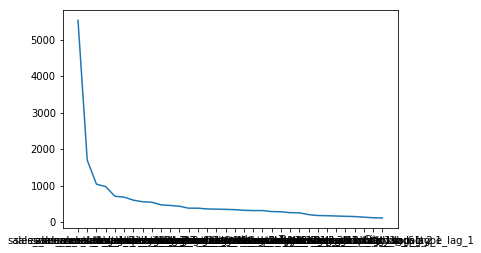

In [32]:
a = {k: clf[k].get_score(importance_type='gain') for k in clf.keys()}

b = pd.DataFrame(a)

b.columns = list(range(n_split))

c = b.mean(axis=1).sort_values(ascending=False)

d = c.head(50).index.tolist()
e = []
f = []
for n in d:
    if len(n.split('_'))>=2 and n.split('_')[-2] == 'lag':
        e.append('_'.join(n.split('_')[:-2]))
        f.append(int(n.split('_')[-1]))
        
e = set(e)
f = set(f)

b.to_csv('eda_11_6_feature_importance.csv')

plt.plot(c)

In [33]:
dtrain = xgb.DMatrix(x_train, y_train)
bst = xgb.train(param, dtrain, num_boost_round=n_tree, 
                evals=[(dtrain, 'train')], feval=clip_rmse, maximize=False, 
                verbose_eval=True)

[0]	train-rmse:1.28651	train-clip-rmse:1.05308
[1]	train-rmse:1.17546	train-clip-rmse:0.958029
[2]	train-rmse:1.10923	train-clip-rmse:0.907598
[3]	train-rmse:1.07397	train-clip-rmse:0.882732
[4]	train-rmse:1.04817	train-clip-rmse:0.865898
[5]	train-rmse:1.03244	train-clip-rmse:0.856321
[6]	train-rmse:1.01762	train-clip-rmse:0.847534
[7]	train-rmse:1.00958	train-clip-rmse:0.843146
[8]	train-rmse:1.00332	train-clip-rmse:0.839893
[9]	train-rmse:0.99796	train-clip-rmse:0.836906
[10]	train-rmse:0.994891	train-clip-rmse:0.835014
[11]	train-rmse:0.991187	train-clip-rmse:0.833055
[12]	train-rmse:0.986816	train-clip-rmse:0.830095
[13]	train-rmse:0.97877	train-clip-rmse:0.825326
[14]	train-rmse:0.976144	train-clip-rmse:0.823772
[15]	train-rmse:0.971939	train-clip-rmse:0.820839
[16]	train-rmse:0.970135	train-clip-rmse:0.819547
[17]	train-rmse:0.963384	train-clip-rmse:0.815093
[18]	train-rmse:0.961317	train-clip-rmse:0.813528
[19]	train-rmse:0.957914	train-clip-rmse:0.81146
[20]	train-rmse:0.95623

In [34]:
preds = bst.predict(xgb.DMatrix(x_test))
preds = list(map(lambda x: min(20, max(x, 0)), list(preds)))
sub_df = pd.DataFrame({'ID': test.index, 'item_cnt_month': preds})
sub_df.to_csv('eda_11_6.csv', index=False)